# Introduction

This notebook will be used only to analyze data from the third Vanilla execution. The experiment setup is as follows:

1. Execution was done on Comet.
2. The core count was 16,64,256,1024 cores
3. One CU per core
4. The calculation was done over 128 trajectories and the whole matrix was calculated.
5. Each trajectory file has 102 frames of 214 atoms each.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import csv
import pandas
from matplotlib import cm

blues = cm.get_cmap(plt.get_cmap('Blues'))
greens = cm.get_cmap(plt.get_cmap('Greens'))
reds = cm.get_cmap(plt.get_cmap('Reds'))

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def CsvToPandas(csvfile):
    csv_data = list()
    for row in csvfile:
        if row[0].startswith('unit.'):
            csv_data.append(float(row[-2]))
    csvdata=np.array(csv_data)
    return csvdata.max()

In [3]:
def SparkLogToDataFrame(filename,path):
    import json
    import pandas
    import numpy as np

    columns=['TaskId','LaunchTime','SchedulerDelay','DeserializeTime','Runtime','ResultSerialization','FinishTime','ResultSize']

    stat_file=open(path+filename)
    stats=list();
    for line in stat_file:
        stats.append(json.loads(line))

    data=pandas.DataFrame(columns=columns,dtype=np.int64)
    data_point = np.zeros((8,1),dtype=np.int64)
    for stat in stats:
        if stat['Event'] == 'SparkListenerTaskEnd':
            data_point[0] = int(stat['Task Info']['Task ID'])
            data_point[1] = int(stat['Task Info']['Launch Time'])
            data_point[3] = int(stat['Task Metrics']['Executor Deserialize Time'])
            data_point[4] = int(stat['Task Metrics']['Executor Run Time'])
            data_point[5] = int(stat['Task Metrics']['Result Serialization Time'])
            data_point[6] = int(stat['Task Info']['Finish Time'])
            data_point[7] = int(stat['Task Metrics']['Result Size'])
            data_point[2] = data_point[6] - (data_point[1] + data_point[3] \
                                           + data_point[4] + data_point[5])
            data_case = pandas.DataFrame(data_point.reshape((1,8)),columns=columns)
            data = data.append(data_case,ignore_index=True)
            
    return data


In [4]:
def SparkSessionToDataFrame(sessionName,path,appName):
    import json
    import pandas
    import numpy as np

    columns=['TaskId','LaunchTime','SchedulerDelay','DeserializeTime','Runtime','ResultSerialization','FinishTime','ResultSize','ReadTime','Exec']
    data=pandas.DataFrame(np.zeros((1,10)),columns=columns,dtype=np.int64)
    data_point = np.zeros((10,1),dtype=np.int64)
    
    if appName != 'miss':
        appPath = path + sessionName + '/unit.000000/' + appName
        print appPath
        timings = np.load(path + sessionName + '/unit.000000/timing.npz.npy')

        stat_file=open(appPath)
        stats=list();
        for line in stat_file:
            stats.append(json.loads(line))

        for stat in stats:
            if stat['Event'] == 'SparkListenerTaskEnd':
                data_point[0] = int(stat['Task Info']['Task ID'])
                data_point[1] = int(stat['Task Info']['Launch Time'])
                data_point[3] = int(stat['Task Metrics']['Executor Deserialize Time'])
                data_point[4] = int(stat['Task Metrics']['Executor Run Time'])
                data_point[5] = int(stat['Task Metrics']['Result Serialization Time'])
                data_point[6] = int(stat['Task Info']['Finish Time'])
                data_point[7] = int(stat['Task Metrics']['Result Size'])
                data_point[2] = data_point[6] - (data_point[1] + data_point[3] \
                                           + data_point[4] + data_point[5])
                data_point[8] = timings[data_point[0],1]-timings[data_point[0],0]
                data_point[9] = timings[data_point[0],2]-timings[data_point[0],1]
                data_case = pandas.DataFrame(data_point.reshape((1,10)),columns=columns)
                data = data.append(data_case,ignore_index=True)
            
    return data

In [5]:
def SessionToPandas(path,sessionName,cores):
    
    unit_path = path+sessionName+'/'
    
    sessionDataFrame = pandas.DataFrame(columns=['Read','Exec','Write'],dtype=np.float)
    for i in range(0,cores):
        data_point = np.zeros((1,3),dtype=np.float)
        stdoutFile = open(unit_path + 'unit.%06i'%i+'/STDOUT')
        for line in stdoutFile:
            if line.startswith('Data Read:'):
                lineList=line.split()
                data_point[0,0] = np.float(lineList[2])
                data_point[0,1] = np.float(lineList[5])
            elif line.startswith('Total Time'):
                lineList = line.split()
                data_point[0,2] = np.float(lineList[6]) - data_point[0,0] - data_point[0,1]
            
        sessionDataFrame = sessionDataFrame.append(pandas.DataFrame((data_point),columns=['Read','Exec','Write']),ignore_index=True)
            
    return sessionDataFrame

# 1. Vanilla Experiments

## 1.1 Setting up everything

In [6]:
rp_haus_16_32_short_aa_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_16_32_short_aa_1.csv',index_col=None)
rp_haus_16_32_short_aa_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_16_32_short_aa_2.csv',index_col=None)
rp_haus_16_32_short_aa_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_16_32_short_aa_3.csv',index_col=None)
rp_haus_64_16_short_aa_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_64_16_short_aa_1.csv',index_col=None)
rp_haus_64_16_short_aa_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_64_16_short_aa_2.csv',index_col=None)
rp_haus_64_16_short_aa_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_64_16_short_aa_3.csv',index_col=None)
rp_haus_256_8_short_aa_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_256_8_short_aa_1.csv',index_col=None)
rp_haus_256_8_short_aa_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_256_8_short_aa_2.csv',index_col=None)
rp_haus_256_8_short_aa_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_256_8_short_aa_3.csv',index_col=None)
rp_haus_1024_4_short_aa_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_1024_4_short_aa_1.csv',index_col=None)
rp_haus_1024_4_short_aa_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_1024_4_short_aa_2.csv',index_col=None)
rp_haus_1024_4_short_aa_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_1024_4_short_aa_3.csv',index_col=None)

rp_haus_16_32_med_aa_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_16_32_med_aa_1.csv',index_col=None)
rp_haus_16_32_med_aa_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_16_32_med_aa_2.csv',index_col=None)
rp_haus_16_32_med_aa_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_16_32_med_aa_3.csv',index_col=None)
rp_haus_64_16_med_aa_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_64_16_med_aa_1.csv',index_col=None)
rp_haus_64_16_med_aa_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_64_16_med_aa_2.csv',index_col=None)
rp_haus_64_16_med_aa_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_64_16_med_aa_3.csv',index_col=None)
rp_haus_256_8_med_aa_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_256_8_med_aa_1.csv',index_col=None)
rp_haus_256_8_med_aa_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_256_8_med_aa_2.csv',index_col=None)
rp_haus_256_8_med_aa_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_256_8_med_aa_3.csv',index_col=None)
#rp_haus_1024_4_med_aa_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_1024_4_med_aa_1.csv',index_col=None)
#rp_haus_1024_4_med_aa_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_1024_4_med_aa_2.csv',index_col=None)
#rp_haus_1024_4_med_aa_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_1024_4_med_aa_3.csv',index_col=None)

rp_haus_16_32_long_aa_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_16_32_long_aa_1.csv',index_col=None)
rp_haus_16_32_long_aa_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_16_32_long_aa_2.csv',index_col=None)
rp_haus_16_32_long_aa_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_16_32_long_aa_3.csv',index_col=None)
rp_haus_64_16_long_aa_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_64_16_long_aa_1.csv',index_col=None)
rp_haus_64_16_long_aa_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_64_16_long_aa_2.csv',index_col=None)
rp_haus_64_16_long_aa_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_64_16_long_aa_3.csv',index_col=None)
rp_haus_256_8_long_aa_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_256_8_long_aa_1.csv',index_col=None)
rp_haus_256_8_long_aa_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_256_8_long_aa_2.csv',index_col=None)
rp_haus_256_8_long_aa_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_256_8_long_aa_3.csv',index_col=None)
#rp_haus_1024_4_long_aa_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_1024_4_long_aa_1.csv',index_col=None)
#rp_haus_1024_4_long_aa_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_1024_4_long_aa_2.csv',index_col=None)
#rp_haus_1024_4_long_aa_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter4/rpco_haus_1024_4_long_aa_3.csv',index_col=None)


In [7]:
rp_haus_16_32_short_aa_tmp = pandas.concat([rp_haus_16_32_short_aa_1,rp_haus_16_32_short_aa_2,rp_haus_16_32_short_aa_3],ignore_index=True)
rp_haus_64_16_short_aa_tmp = pandas.concat([rp_haus_64_16_short_aa_1,rp_haus_64_16_short_aa_2,rp_haus_64_16_short_aa_3],ignore_index=True)
rp_haus_256_8_short_aa_tmp = pandas.concat([rp_haus_256_8_short_aa_1,rp_haus_256_8_short_aa_2,rp_haus_256_8_short_aa_3],ignore_index=True)
rp_haus_1024_4_short_aa_tmp = pandas.concat([rp_haus_1024_4_short_aa_1,rp_haus_1024_4_short_aa_2,rp_haus_1024_4_short_aa_3],ignore_index=True)

rp_haus_16_32_med_aa_tmp = pandas.concat([rp_haus_16_32_med_aa_1,rp_haus_16_32_med_aa_2,rp_haus_16_32_med_aa_3],ignore_index=True)
rp_haus_64_16_med_aa_tmp = pandas.concat([rp_haus_64_16_med_aa_1,rp_haus_64_16_med_aa_2,rp_haus_64_16_med_aa_3],ignore_index=True)
rp_haus_256_8_med_aa_tmp = pandas.concat([rp_haus_256_8_med_aa_1,rp_haus_256_8_med_aa_2,rp_haus_256_8_med_aa_3],ignore_index=True)
#rp_haus_1024_4_med_aa_tmp = pandas.concat([rp_haus_1024_4_med_aa_1,rp_haus_1024_4_med_aa_2,rp_haus_1024_4_med_aa_3],ignore_index=True)

rp_haus_16_32_long_aa_tmp = pandas.concat([rp_haus_16_32_long_aa_1,rp_haus_16_32_long_aa_2,rp_haus_16_32_long_aa_3],ignore_index=True)
rp_haus_64_16_long_aa_tmp = pandas.concat([rp_haus_64_16_long_aa_1,rp_haus_64_16_long_aa_2,rp_haus_64_16_long_aa_3],ignore_index=True)
rp_haus_256_8_long_aa_tmp = pandas.concat([rp_haus_256_8_long_aa_1,rp_haus_256_8_long_aa_2,rp_haus_256_8_long_aa_3],ignore_index=True)
#rp_haus_1024_4_long_aa_tmp = pandas.concat([rp_haus_1024_4_long_aa_1,rp_haus_1024_4_long_aa_2,rp_haus_1024_4_long_aa_3],ignore_index=True)

## Dataframes for statistics

In [8]:
rp_haus_16_32_short = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_16_32_short['StageInPending']= rp_haus_16_32_short_aa_tmp['StageIn'].sort_values()
rp_haus_16_32_short['SchedulerDelay']= rp_haus_16_32_short_aa_tmp['Exec']-rp_haus_16_32_short_aa_tmp['Allocate']
rp_haus_16_32_short['StageInDelay'] = rp_haus_16_32_short_aa_tmp['Allocate']-rp_haus_16_32_short_aa_tmp['StageIn']
rp_haus_16_32_short['Execution'] = rp_haus_16_32_short_aa_tmp['StageOut']-rp_haus_16_32_short_aa_tmp['Exec']
rp_haus_16_32_short['StageOut'] = rp_haus_16_32_short_aa_tmp['Done']-rp_haus_16_32_short_aa_tmp['StageOut']
rp_haus_16_32_short['TotalTime'] = rp_haus_16_32_short_aa_tmp['StageOut']-rp_haus_16_32_short_aa_tmp['StageIn']

rp_haus_64_16_short = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_64_16_short['StageInPending'] = rp_haus_64_16_short_aa_tmp['StageIn'].sort_values()
rp_haus_64_16_short['SchedulerDelay']= rp_haus_64_16_short_aa_tmp['Exec']-rp_haus_64_16_short_aa_tmp['Allocate']
rp_haus_64_16_short['StageInDelay'] = rp_haus_64_16_short_aa_tmp['Allocate']-rp_haus_64_16_short_aa_tmp['StageIn']
rp_haus_64_16_short['Execution'] = rp_haus_64_16_short_aa_tmp['StageOut']-rp_haus_64_16_short_aa_tmp['Exec']
rp_haus_64_16_short['StageOut'] = rp_haus_64_16_short_aa_tmp['Done']-rp_haus_64_16_short_aa_tmp['StageOut']
rp_haus_64_16_short['TotalTime'] = rp_haus_64_16_short_aa_tmp['StageOut']-rp_haus_64_16_short_aa_tmp['StageIn']

rp_haus_256_8_short = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_256_8_short['StageInPending'] = rp_haus_256_8_short_aa_tmp['StageIn'].sort_values()
rp_haus_256_8_short['SchedulerDelay']= rp_haus_256_8_short_aa_tmp['Exec']-rp_haus_256_8_short_aa_tmp['Allocate']
rp_haus_256_8_short['StageInDelay'] = rp_haus_256_8_short_aa_tmp['Allocate']-rp_haus_256_8_short_aa_tmp['StageIn']
rp_haus_256_8_short['Execution'] = rp_haus_256_8_short_aa_tmp['StageOut']-rp_haus_256_8_short_aa_tmp['Exec']
rp_haus_256_8_short['StageOut'] = rp_haus_256_8_short_aa_tmp['Done']-rp_haus_256_8_short_aa_tmp['StageOut']
rp_haus_256_8_short['TotalTime'] = rp_haus_256_8_short_aa_tmp['StageOut']-rp_haus_256_8_short_aa_tmp['StageIn']

rp_haus_1024_4_short = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_1024_4_short['StageInPending'] = rp_haus_1024_4_short_aa_tmp['StageIn'].sort_values()
rp_haus_1024_4_short['SchedulerDelay']= rp_haus_1024_4_short_aa_tmp['Exec']-rp_haus_1024_4_short_aa_tmp['Allocate']
rp_haus_1024_4_short['StageInDelay'] = rp_haus_1024_4_short_aa_tmp['Allocate']-rp_haus_1024_4_short_aa_tmp['StageIn']
rp_haus_1024_4_short['Execution'] = rp_haus_1024_4_short_aa_tmp['StageOut']-rp_haus_1024_4_short_aa_tmp['Exec']
rp_haus_1024_4_short['StageOut'] = rp_haus_1024_4_short_aa_tmp['Done']-rp_haus_1024_4_short_aa_tmp['StageOut']
rp_haus_1024_4_short['TotalTime'] = rp_haus_1024_4_short_aa_tmp['StageOut']-rp_haus_1024_4_short_aa_tmp['StageIn']

rp_haus_16_32_med = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_16_32_med['StageInPending']= rp_haus_16_32_med_aa_tmp['StageIn'].sort_values()
rp_haus_16_32_med['SchedulerDelay']= rp_haus_16_32_med_aa_tmp['Exec']-rp_haus_16_32_med_aa_tmp['Allocate']
rp_haus_16_32_med['StageInDelay'] = rp_haus_16_32_med_aa_tmp['Allocate']-rp_haus_16_32_med_aa_tmp['StageIn']
rp_haus_16_32_med['Execution'] = rp_haus_16_32_med_aa_tmp['StageOut']-rp_haus_16_32_med_aa_tmp['Exec']
rp_haus_16_32_med['StageOut'] = rp_haus_16_32_med_aa_tmp['Done']-rp_haus_16_32_med_aa_tmp['StageOut']
rp_haus_16_32_med['TotalTime'] = rp_haus_16_32_med_aa_tmp['StageOut']-rp_haus_16_32_med_aa_tmp['StageIn']

rp_haus_64_16_med = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_64_16_med['StageInPending'] = rp_haus_64_16_med_aa_tmp['StageIn'].sort_values()
rp_haus_64_16_med['SchedulerDelay']= rp_haus_64_16_med_aa_tmp['Exec']-rp_haus_64_16_med_aa_tmp['Allocate']
rp_haus_64_16_med['StageInDelay'] = rp_haus_64_16_med_aa_tmp['Allocate']-rp_haus_64_16_med_aa_tmp['StageIn']
rp_haus_64_16_med['Execution'] = rp_haus_64_16_med_aa_tmp['StageOut']-rp_haus_64_16_med_aa_tmp['Exec']
rp_haus_64_16_med['StageOut'] = rp_haus_64_16_med_aa_tmp['Done']-rp_haus_64_16_med_aa_tmp['StageOut']
rp_haus_64_16_med['TotalTime'] = rp_haus_64_16_med_aa_tmp['StageOut']-rp_haus_64_16_med_aa_tmp['StageIn']

rp_haus_256_8_med = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_256_8_med['StageInPending'] = rp_haus_256_8_med_aa_tmp['StageIn'].sort_values()
rp_haus_256_8_med['SchedulerDelay']= rp_haus_256_8_med_aa_tmp['Exec']-rp_haus_256_8_med_aa_tmp['Allocate']
rp_haus_256_8_med['StageInDelay'] = rp_haus_256_8_med_aa_tmp['Allocate']-rp_haus_256_8_med_aa_tmp['StageIn']
rp_haus_256_8_med['Execution'] = rp_haus_256_8_med_aa_tmp['StageOut']-rp_haus_256_8_med_aa_tmp['Exec']
rp_haus_256_8_med['StageOut'] = rp_haus_256_8_med_aa_tmp['Done']-rp_haus_256_8_med_aa_tmp['StageOut']
rp_haus_256_8_med['TotalTime'] = rp_haus_256_8_med_aa_tmp['StageOut']-rp_haus_256_8_med_aa_tmp['StageIn']

#rp_haus_1024_4_med = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
#rp_haus_1024_4_med['StageInPending'] = rp_haus_1024_4_med_aa_tmp['StageIn'].sort_values()
#rp_haus_1024_4_med['SchedulerDelay']= rp_haus_1024_4_med_aa_tmp['Exec']-rp_haus_1024_4_med_aa_tmp['Allocate']
#rp_haus_1024_4_med['StageInDelay'] = rp_haus_1024_4_med_aa_tmp['Allocate']-rp_haus_1024_4_med_aa_tmp['StageIn']
#rp_haus_1024_4_med['Execution'] = rp_haus_1024_4_med_aa_tmp['StageOut']-rp_haus_1024_4_med_aa_tmp['Exec']
#rp_haus_1024_4_med['StageOut'] = rp_haus_1024_4_med_aa_tmp['Done']-rp_haus_1024_4_med_aa_tmp['StageOut']
#rp_haus_1024_4_med['TotalTime'] = rp_haus_1024_4_med_aa_tmp['StageOut']-rp_haus_1024_4_med_aa_tmp['StageIn']

rp_haus_16_32_long = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_16_32_long['StageInPending']= rp_haus_16_32_long_aa_tmp['StageIn'].sort_values()
rp_haus_16_32_long['SchedulerDelay']= rp_haus_16_32_long_aa_tmp['Exec']-rp_haus_16_32_long_aa_tmp['Allocate']
rp_haus_16_32_long['StageInDelay'] = rp_haus_16_32_long_aa_tmp['Allocate']-rp_haus_16_32_long_aa_tmp['StageIn']
rp_haus_16_32_long['Execution'] = rp_haus_16_32_long_aa_tmp['StageOut']-rp_haus_16_32_long_aa_tmp['Exec']
rp_haus_16_32_long['StageOut'] = rp_haus_16_32_long_aa_tmp['Done']-rp_haus_16_32_long_aa_tmp['StageOut']
rp_haus_16_32_long['TotalTime'] = rp_haus_16_32_long_aa_tmp['StageOut']-rp_haus_16_32_long_aa_tmp['StageIn']

rp_haus_64_16_long = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_64_16_long['StageInPending'] = rp_haus_64_16_long_aa_tmp['StageIn'].sort_values()
rp_haus_64_16_long['SchedulerDelay']= rp_haus_64_16_long_aa_tmp['Exec']-rp_haus_64_16_long_aa_tmp['Allocate']
rp_haus_64_16_long['StageInDelay'] = rp_haus_64_16_long_aa_tmp['Allocate']-rp_haus_64_16_long_aa_tmp['StageIn']
rp_haus_64_16_long['Execution'] = rp_haus_64_16_long_aa_tmp['StageOut']-rp_haus_64_16_long_aa_tmp['Exec']
rp_haus_64_16_long['StageOut'] = rp_haus_64_16_long_aa_tmp['Done']-rp_haus_64_16_long_aa_tmp['StageOut']
rp_haus_64_16_long['TotalTime'] = rp_haus_64_16_long_aa_tmp['StageOut']-rp_haus_64_16_long_aa_tmp['StageIn']

rp_haus_256_8_long = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_256_8_long['StageInPending'] = rp_haus_256_8_long_aa_tmp['StageIn'].sort_values()
rp_haus_256_8_long['SchedulerDelay']= rp_haus_256_8_long_aa_tmp['Exec']-rp_haus_256_8_long_aa_tmp['Allocate']
rp_haus_256_8_long['StageInDelay'] = rp_haus_256_8_long_aa_tmp['Allocate']-rp_haus_256_8_long_aa_tmp['StageIn']
rp_haus_256_8_long['Execution'] = rp_haus_256_8_long_aa_tmp['StageOut']-rp_haus_256_8_long_aa_tmp['Exec']
rp_haus_256_8_long['StageOut'] = rp_haus_256_8_long_aa_tmp['Done']-rp_haus_256_8_long_aa_tmp['StageOut']
rp_haus_256_8_long['TotalTime'] = rp_haus_256_8_long_aa_tmp['StageOut']-rp_haus_256_8_long_aa_tmp['StageIn']

#rp_haus_1024_4_long = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
#rp_haus_1024_4_long['StageInPending'] = rp_haus_1024_4_long_aa_tmp['StageIn'].sort_values()
#rp_haus_1024_4_long['SchedulerDelay']= rp_haus_1024_4_long_aa_tmp['Exec']-rp_haus_1024_4_long_aa_tmp['Allocate']
#rp_haus_1024_4_long['StageInDelay'] = rp_haus_1024_4_long_aa_tmp['Allocate']-rp_haus_1024_4_long_aa_tmp['StageIn']
#rp_haus_1024_4_long['Execution'] = rp_haus_1024_4_long_aa_tmp['StageOut']-rp_haus_1024_4_long_aa_tmp['Exec']
#rp_haus_1024_4_long['StageOut'] = rp_haus_1024_4_long_aa_tmp['Done']-rp_haus_1024_4_long_aa_tmp['StageOut']
#rp_haus_1024_4_long['TotalTime'] = rp_haus_1024_4_long_aa_tmp['StageOut']-rp_haus_1024_4_long_aa_tmp['StageIn']

In [9]:
StageInArrivalTimes = np.concatenate([rp_haus_16_32_short['StageInPending'],rp_haus_64_16_short['StageInPending']])
StageInArrivalTimes = np.concatenate([StageInArrivalTimes,rp_haus_256_8_short['StageInPending']])
StageInArrivalTimes = np.concatenate([StageInArrivalTimes,rp_haus_1024_4_short['StageInPending']])
StageInArrivalTimes = np.concatenate([StageInArrivalTimes,rp_haus_16_32_med['StageInPending']])
StageInArrivalTimes = np.concatenate([StageInArrivalTimes,rp_haus_64_16_med['StageInPending']])
StageInArrivalTimes = np.concatenate([StageInArrivalTimes,rp_haus_256_8_med['StageInPending']])
#StageInArrivalTimes = np.concatenate([StageInArrivalTimes,rp_haus_1024_4_med['StageInPending']])
StageInArrivalTimes = np.concatenate([StageInArrivalTimes,rp_haus_16_32_long['StageInPending']])
StageInArrivalTimes = np.concatenate([StageInArrivalTimes,rp_haus_64_16_long['StageInPending']])
StageInArrivalTimes = np.concatenate([StageInArrivalTimes,rp_haus_256_8_long['StageInPending']])
#StageInArrivalTimes = np.concatenate([StageInArrivalTimes,rp_haus_1024_4_long['StageInPending']])



## 1.2 Overall plotting values

# Spark Experiments

In [10]:
SparkPrExps = pandas.DataFrame.from_csv('Spark/comet6.csv')
data_list=list()
i=0
tidyData = pandas.DataFrame(columns=['TaskTime','SchedulerDelay','DeserializeTime','Runtime','ResultSerialization','ResultSize','ReadTime','Exec'])
for session,name in zip(SparkPrExps['SessionName'],SparkPrExps['JsonName']): 
    data = SparkSessionToDataFrame(session,'Spark/AppDataComet/Iter6/spCoHaus/',name)
    tidyData.loc[i]=[(data['FinishTime'][1:]-data['LaunchTime']).mean()/1000,\
                 data['SchedulerDelay'][1:].mean()/1000,\
                 data['DeserializeTime'][1:].mean()/1000,\
                 data['Runtime'][1:].mean()/1000,\
                 data['ResultSerialization'][1:].mean()/1000,\
                 data['ResultSize'][1:].mean(),\
                 data['ReadTime'][1:].mean(),\
                 data['Exec'][1:].mean()]
    i+=1
    data_list.append(data)
    
SparkPrExps['appData'] = data_list


Spark/AppDataComet/Iter6/spCoHaus/spCoHaus_aa_short_128_16_1/unit.000000/app-20170515234335-0000
Spark/AppDataComet/Iter6/spCoHaus/spCoHaus_aa_short_128_16_2/unit.000000/app-20170516073249-0000
Spark/AppDataComet/Iter6/spCoHaus/spCoHaus_aa_short_128_16_3/unit.000000/app-20170516094427-0000
Spark/AppDataComet/Iter6/spCoHaus/spCoHaus_aa_short_128_64_1/unit.000000/app-20170503173638-0000
Spark/AppDataComet/Iter6/spCoHaus/spCoHaus_aa_short_128_64_2/unit.000000/app-20170503183326-0000
Spark/AppDataComet/Iter6/spCoHaus/spCoHaus_aa_short_128_64_3/unit.000000/app-20170503184707-0000
Spark/AppDataComet/Iter6/spCoHaus/spCoHaus_aa_short_128_256_1/unit.000000/app-20170503213517-0000
Spark/AppDataComet/Iter6/spCoHaus/spCoHaus_aa_short_128_256_2/unit.000000/app-20170503221241-0000
Spark/AppDataComet/Iter6/spCoHaus/spCoHaus_aa_short_128_256_3/unit.000000/app-20170504101201-0000
Spark/AppDataComet/Iter6/spCoHaus/spCoHaus_aa_short_128_1024_1/unit.000000/app-20170504121842-0000
Spark/AppDataComet/Iter6/

In [11]:
# Short Trajectories
spco_stagein_short_ca = np.array([SparkPrExps[0:3]['DataInit'].mean(),
                                  SparkPrExps[3:6]['DataInit'].mean(),
                                  SparkPrExps[6:9]['DataInit'].mean(),
                                  SparkPrExps[9:12]['DataInit'].mean()]).reshape((4,1))

spco_schedulerdelay_short_ca=np.zeros((4,1))
spco_schedulerdelay_short_ca[0] = np.mean([SparkPrExps['appData'][0]['SchedulerDelay'],
                                           SparkPrExps['appData'][1]['SchedulerDelay'],
                                           SparkPrExps['appData'][2]['SchedulerDelay']])/1000
spco_schedulerdelay_short_ca[1] = np.mean([SparkPrExps['appData'][3]['SchedulerDelay'],
                                           SparkPrExps['appData'][4]['SchedulerDelay'],
                                           SparkPrExps['appData'][5]['SchedulerDelay']])/1000
spco_schedulerdelay_short_ca[2] = np.mean([SparkPrExps['appData'][6]['SchedulerDelay'],
                                           SparkPrExps['appData'][7]['SchedulerDelay'],
                                           SparkPrExps['appData'][8]['SchedulerDelay']])/1000
spco_schedulerdelay_short_ca[3] = np.mean([SparkPrExps['appData'][9]['SchedulerDelay'],
                                           SparkPrExps['appData'][10]['SchedulerDelay'],
                                           SparkPrExps['appData'][11]['SchedulerDelay']])/1000

spco_execution_short_ca = np.zeros((4,1))
spco_execution_short_ca[0] = np.mean([(SparkPrExps['appData'][0]['Runtime']+SparkPrExps['appData'][0]['DeserializeTime']+SparkPrExps['appData'][0]['ResultSerialization']),
                                      (SparkPrExps['appData'][1]['Runtime']+SparkPrExps['appData'][1]['DeserializeTime']+SparkPrExps['appData'][1]['ResultSerialization']),
                                      (SparkPrExps['appData'][2]['Runtime']+SparkPrExps['appData'][2]['DeserializeTime']+SparkPrExps['appData'][2]['ResultSerialization'])])/1000
spco_execution_short_ca[1] = np.mean([(SparkPrExps['appData'][3]['Runtime']+SparkPrExps['appData'][3]['DeserializeTime']+SparkPrExps['appData'][3]['ResultSerialization']),
                                      (SparkPrExps['appData'][4]['Runtime']+SparkPrExps['appData'][4]['DeserializeTime']+SparkPrExps['appData'][4]['ResultSerialization']),
                                      (SparkPrExps['appData'][5]['Runtime']+SparkPrExps['appData'][5]['DeserializeTime']+SparkPrExps['appData'][5]['ResultSerialization'])])/1000
spco_execution_short_ca[2] = np.mean([(SparkPrExps['appData'][6]['Runtime']+SparkPrExps['appData'][6]['DeserializeTime']+SparkPrExps['appData'][6]['ResultSerialization']),
                                      (SparkPrExps['appData'][7]['Runtime']+SparkPrExps['appData'][7]['DeserializeTime']+SparkPrExps['appData'][7]['ResultSerialization']),
                                      (SparkPrExps['appData'][8]['Runtime']+SparkPrExps['appData'][8]['DeserializeTime']+SparkPrExps['appData'][8]['ResultSerialization'])])/1000
spco_execution_short_ca[3] = np.mean([(SparkPrExps['appData'][9]['Runtime']+SparkPrExps['appData'][9]['DeserializeTime']+SparkPrExps['appData'][9]['ResultSerialization']),
                                      (SparkPrExps['appData'][10]['Runtime']+SparkPrExps['appData'][10]['DeserializeTime']+SparkPrExps['appData'][10]['ResultSerialization']),
                                      (SparkPrExps['appData'][11]['Runtime']+SparkPrExps['appData'][11]['DeserializeTime']+SparkPrExps['appData'][11]['ResultSerialization'])])/1000

spco_stageout_short_ca = np.zeros((4,1))
spco_stageout_short_ca[0] = np.mean([(SparkPrExps['TotalTime'][0] - (SparkPrExps['appData'][0]['FinishTime'] - SparkPrExps['appData'][0]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][1] - (SparkPrExps['appData'][1]['FinishTime'] - SparkPrExps['appData'][1]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][2] - (SparkPrExps['appData'][2]['FinishTime'] - SparkPrExps['appData'][2]['LaunchTime'])/1000)])
spco_stageout_short_ca[1] = np.mean([(SparkPrExps['TotalTime'][3] - (SparkPrExps['appData'][3]['FinishTime'] - SparkPrExps['appData'][3]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][4] - (SparkPrExps['appData'][4]['FinishTime'] - SparkPrExps['appData'][4]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][5] - (SparkPrExps['appData'][5]['FinishTime'] - SparkPrExps['appData'][5]['LaunchTime'])/1000)])
spco_stageout_short_ca[2] = np.mean([(SparkPrExps['TotalTime'][6] - (SparkPrExps['appData'][6]['FinishTime'] - SparkPrExps['appData'][6]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][7] - (SparkPrExps['appData'][7]['FinishTime'] - SparkPrExps['appData'][7]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][8] - (SparkPrExps['appData'][8]['FinishTime'] - SparkPrExps['appData'][8]['LaunchTime'])/1000)])
spco_stageout_short_ca[3] = np.mean([(SparkPrExps['TotalTime'][9] - (SparkPrExps['appData'][9]['FinishTime'] - SparkPrExps['appData'][9]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][10] - (SparkPrExps['appData'][10]['FinishTime'] - SparkPrExps['appData'][10]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][11] - (SparkPrExps['appData'][11]['FinishTime'] - SparkPrExps['appData'][11]['LaunchTime'])/1000)])



In [12]:
# Medium Trajectory
spco_stagein_med_ca = np.array([SparkPrExps[12:15]['DataInit'].mean(),
                                SparkPrExps[15:18]['DataInit'].mean(),
                                SparkPrExps[18:21]['DataInit'].mean(),
                                SparkPrExps[21:24]['DataInit'].mean()]).reshape((4,1))

spco_schedulerdelay_med_ca=np.zeros((4,1))
spco_schedulerdelay_med_ca[0] = np.mean([SparkPrExps['appData'][12]['SchedulerDelay'],
                                         SparkPrExps['appData'][13]['SchedulerDelay'],
                                         SparkPrExps['appData'][14]['SchedulerDelay']])/1000
spco_schedulerdelay_med_ca[1] = np.mean([SparkPrExps['appData'][15]['SchedulerDelay'],
                                         SparkPrExps['appData'][16]['SchedulerDelay'],
                                         SparkPrExps['appData'][17]['SchedulerDelay']])/1000
spco_schedulerdelay_med_ca[2] = np.mean([SparkPrExps['appData'][18]['SchedulerDelay'],
                                         SparkPrExps['appData'][19]['SchedulerDelay'],
                                         SparkPrExps['appData'][20]['SchedulerDelay']])/1000
spco_schedulerdelay_med_ca[3] = np.mean([SparkPrExps['appData'][21]['SchedulerDelay'],
                                         SparkPrExps['appData'][22]['SchedulerDelay'],
                                         SparkPrExps['appData'][23]['SchedulerDelay']])/1000


spco_execution_med_ca = np.zeros((4,1))
spco_execution_med_ca[0] = np.mean([(SparkPrExps['appData'][12]['Runtime']+SparkPrExps['appData'][12]['DeserializeTime']+SparkPrExps['appData'][12]['ResultSerialization']),
                                    (SparkPrExps['appData'][13]['Runtime']+SparkPrExps['appData'][13]['DeserializeTime']+SparkPrExps['appData'][13]['ResultSerialization']),
                                    (SparkPrExps['appData'][14]['Runtime']+SparkPrExps['appData'][14]['DeserializeTime']+SparkPrExps['appData'][14]['ResultSerialization'])])/1000
spco_execution_med_ca[1] = np.mean([(SparkPrExps['appData'][15]['Runtime']+SparkPrExps['appData'][15]['DeserializeTime']+SparkPrExps['appData'][15]['ResultSerialization']),
                                    (SparkPrExps['appData'][16]['Runtime']+SparkPrExps['appData'][16]['DeserializeTime']+SparkPrExps['appData'][16]['ResultSerialization']),
                                    (SparkPrExps['appData'][17]['Runtime']+SparkPrExps['appData'][17]['DeserializeTime']+SparkPrExps['appData'][17]['ResultSerialization'])])/1000
spco_execution_med_ca[2] = np.mean([(SparkPrExps['appData'][18]['Runtime']+SparkPrExps['appData'][18]['DeserializeTime']+SparkPrExps['appData'][18]['ResultSerialization']),
                                    (SparkPrExps['appData'][19]['Runtime']+SparkPrExps['appData'][19]['DeserializeTime']+SparkPrExps['appData'][19]['ResultSerialization']),
                                    (SparkPrExps['appData'][20]['Runtime']+SparkPrExps['appData'][20]['DeserializeTime']+SparkPrExps['appData'][20]['ResultSerialization'])])/1000
spco_execution_med_ca[3] = np.mean([(SparkPrExps['appData'][21]['Runtime']+SparkPrExps['appData'][21]['DeserializeTime']+SparkPrExps['appData'][21]['ResultSerialization']),
                                    (SparkPrExps['appData'][22]['Runtime']+SparkPrExps['appData'][22]['DeserializeTime']+SparkPrExps['appData'][22]['ResultSerialization']),
                                    (SparkPrExps['appData'][23]['Runtime']+SparkPrExps['appData'][23]['DeserializeTime']+SparkPrExps['appData'][23]['ResultSerialization'])])/1000

spco_stageout_med_ca = np.zeros((4,1))
spco_stageout_med_ca[0] = np.mean([(SparkPrExps['TotalTime'][12] - (SparkPrExps['appData'][12]['FinishTime'] - SparkPrExps['appData'][12]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][13] - (SparkPrExps['appData'][13]['FinishTime'] - SparkPrExps['appData'][13]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][14] - (SparkPrExps['appData'][14]['FinishTime'] - SparkPrExps['appData'][14]['LaunchTime'])/1000)])
spco_stageout_med_ca[1] = np.mean([(SparkPrExps['TotalTime'][15] - (SparkPrExps['appData'][15]['FinishTime'] - SparkPrExps['appData'][15]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][16] - (SparkPrExps['appData'][16]['FinishTime'] - SparkPrExps['appData'][16]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][17] - (SparkPrExps['appData'][17]['FinishTime'] - SparkPrExps['appData'][17]['LaunchTime'])/1000)])
spco_stageout_med_ca[2] = np.mean([(SparkPrExps['TotalTime'][18] - (SparkPrExps['appData'][18]['FinishTime'] - SparkPrExps['appData'][18]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][19] - (SparkPrExps['appData'][19]['FinishTime'] - SparkPrExps['appData'][19]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][20] - (SparkPrExps['appData'][20]['FinishTime'] - SparkPrExps['appData'][20]['LaunchTime'])/1000)])
spco_stageout_med_ca[3] = np.mean([(SparkPrExps['TotalTime'][21] - (SparkPrExps['appData'][21]['FinishTime'] - SparkPrExps['appData'][21]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][22] - (SparkPrExps['appData'][22]['FinishTime'] - SparkPrExps['appData'][22]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][23] - (SparkPrExps['appData'][23]['FinishTime'] - SparkPrExps['appData'][23]['LaunchTime'])/1000)])



In [13]:
# Long Trajectory
spco_stagein_long_ca = np.array([SparkPrExps[24:27]['DataInit'].mean(),
                                 SparkPrExps[27:30]['DataInit'].mean(),
                                 SparkPrExps[30:33]['DataInit'].mean(),
                                 SparkPrExps[33:36]['DataInit'].mean()]).reshape((4,1))

spco_schedulerdelay_long_ca=np.zeros((4,1))
spco_schedulerdelay_long_ca[0] = np.mean([SparkPrExps['appData'][24]['SchedulerDelay'],
                                          SparkPrExps['appData'][25]['SchedulerDelay'],
                                          SparkPrExps['appData'][26]['SchedulerDelay']])/1000
spco_schedulerdelay_long_ca[1] = np.mean([SparkPrExps['appData'][27]['SchedulerDelay'],
                                          SparkPrExps['appData'][28]['SchedulerDelay'],
                                          SparkPrExps['appData'][29]['SchedulerDelay']])/1000
spco_schedulerdelay_long_ca[2] = np.mean([SparkPrExps['appData'][30]['SchedulerDelay'],
                                          SparkPrExps['appData'][31]['SchedulerDelay'],
                                          SparkPrExps['appData'][32]['SchedulerDelay']])/1000
spco_schedulerdelay_long_ca[3] = np.mean([SparkPrExps['appData'][33]['SchedulerDelay'],
                                          SparkPrExps['appData'][34]['SchedulerDelay'],
                                          SparkPrExps['appData'][35]['SchedulerDelay']])/1000

spco_execution_long_ca = np.zeros((4,1))
spco_execution_long_ca[0] = np.mean([(SparkPrExps['appData'][24]['Runtime']+SparkPrExps['appData'][24]['DeserializeTime']+SparkPrExps['appData'][24]['ResultSerialization']),
                                     (SparkPrExps['appData'][25]['Runtime']+SparkPrExps['appData'][25]['DeserializeTime']+SparkPrExps['appData'][25]['ResultSerialization']),
                                     (SparkPrExps['appData'][26]['Runtime']+SparkPrExps['appData'][26]['DeserializeTime']+SparkPrExps['appData'][26]['ResultSerialization'])])/1000
spco_execution_long_ca[1] = np.mean([(SparkPrExps['appData'][27]['Runtime']+SparkPrExps['appData'][27]['DeserializeTime']+SparkPrExps['appData'][27]['ResultSerialization']),
                                     (SparkPrExps['appData'][28]['Runtime']+SparkPrExps['appData'][28]['DeserializeTime']+SparkPrExps['appData'][28]['ResultSerialization']),
                                     (SparkPrExps['appData'][29]['Runtime']+SparkPrExps['appData'][29]['DeserializeTime']+SparkPrExps['appData'][29]['ResultSerialization'])])/1000
spco_execution_long_ca[2] = np.mean([(SparkPrExps['appData'][30]['Runtime']+SparkPrExps['appData'][30]['DeserializeTime']+SparkPrExps['appData'][30]['ResultSerialization']),
                                     (SparkPrExps['appData'][31]['Runtime']+SparkPrExps['appData'][31]['DeserializeTime']+SparkPrExps['appData'][31]['ResultSerialization']),
                                     (SparkPrExps['appData'][32]['Runtime']+SparkPrExps['appData'][32]['DeserializeTime']+SparkPrExps['appData'][32]['ResultSerialization'])])/1000
spco_execution_long_ca[3] = np.mean([(SparkPrExps['appData'][33]['Runtime']+SparkPrExps['appData'][33]['DeserializeTime']+SparkPrExps['appData'][33]['ResultSerialization']),
                                     (SparkPrExps['appData'][34]['Runtime']+SparkPrExps['appData'][34]['DeserializeTime']+SparkPrExps['appData'][34]['ResultSerialization']),
                                     (SparkPrExps['appData'][35]['Runtime']+SparkPrExps['appData'][35]['DeserializeTime']+SparkPrExps['appData'][35]['ResultSerialization'])])/1000

spco_stageout_long_ca = np.zeros((4,1))
spco_stageout_long_ca[0] = np.mean([(SparkPrExps['TotalTime'][24] - (SparkPrExps['appData'][24]['FinishTime'] - SparkPrExps['appData'][24]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][25] - (SparkPrExps['appData'][25]['FinishTime'] - SparkPrExps['appData'][25]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][26] - (SparkPrExps['appData'][26]['FinishTime'] - SparkPrExps['appData'][26]['LaunchTime'])/1000)])
spco_stageout_long_ca[1] = np.mean([(SparkPrExps['TotalTime'][27] - (SparkPrExps['appData'][27]['FinishTime'] - SparkPrExps['appData'][27]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][28] - (SparkPrExps['appData'][28]['FinishTime'] - SparkPrExps['appData'][28]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][29] - (SparkPrExps['appData'][29]['FinishTime'] - SparkPrExps['appData'][29]['LaunchTime'])/1000)])
spco_stageout_long_ca[2] = np.mean([(SparkPrExps['TotalTime'][30] - (SparkPrExps['appData'][30]['FinishTime'] - SparkPrExps['appData'][30]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][31] - (SparkPrExps['appData'][31]['FinishTime'] - SparkPrExps['appData'][31]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][32] - (SparkPrExps['appData'][32]['FinishTime'] - SparkPrExps['appData'][32]['LaunchTime'])/1000)])
spco_stageout_long_ca[3] = np.mean([(SparkPrExps['TotalTime'][33] - (SparkPrExps['appData'][33]['FinishTime'] - SparkPrExps['appData'][33]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][34] - (SparkPrExps['appData'][34]['FinishTime'] - SparkPrExps['appData'][34]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][35] - (SparkPrExps['appData'][35]['FinishTime'] - SparkPrExps['appData'][35]['LaunchTime'])/1000)])



# Dask Measurements

In [14]:
DaskDataframe=pandas.DataFrame(columns=['Size','Cores','Dask Execution'])
DaskDataframe.loc[0] = ['Short',16,593.86]
DaskDataframe.loc[1] = ['Short',64,173.1]
DaskDataframe.loc[2] = ['Short',256,45.29]
DaskDataframe.loc[3] = ['Short',1024,16.2]

DaskDataframe.loc[4] = ['Med',16,1048.3]
DaskDataframe.loc[5] = ['Med',64,318.27]
DaskDataframe.loc[6] = ['Med',256,79.37]
DaskDataframe.loc[7] = ['Med',1024,25.9]

DaskDataframe.loc[8] = ['Long',16,1910]
DaskDataframe.loc[9] = ['Long',64,645.95]
DaskDataframe.loc[10] = ['Long',256,165.88]
DaskDataframe.loc[11] = ['Long',1024,43.63]

# Plotting

In [16]:
rp_haus_short_plot=pandas.DataFrame(columns=['RADICAL-Pilot Overhead','RADICAL-Pilot Execution'])
data=[np.mean([rp_haus_16_32_short['StageInPending'][0:16].max(),rp_haus_16_32_short['StageInPending'][16:32].max(),rp_haus_16_32_short['StageInPending'][32:48].max()])+\
      rp_haus_16_32_short['StageInDelay'].mean()+\
      rp_haus_16_32_short['SchedulerDelay'].mean(),\
      rp_haus_16_32_short['Execution'].mean()]
rp_haus_short_plot.loc[16]=data
data=[np.mean([rp_haus_64_16_short['StageInPending'][0:64].max(),rp_haus_64_16_short['StageInPending'][64:128].max(),rp_haus_64_16_short['StageInPending'][128:192].max()])+\
      rp_haus_64_16_short['StageInDelay'].mean()+\
      rp_haus_64_16_short['SchedulerDelay'].mean(),\
      rp_haus_64_16_short['Execution'].mean()]
rp_haus_short_plot.loc[64]=data
data=[np.mean([rp_haus_256_8_short['StageInPending'][0:256].max(),rp_haus_256_8_short['StageInPending'][256:512].max(),rp_haus_256_8_short['StageInPending'][512:768].max()])+\
      rp_haus_256_8_short['StageInDelay'].mean()+\
      rp_haus_256_8_short['SchedulerDelay'].mean(),\
      rp_haus_256_8_short['Execution'].mean()]
rp_haus_short_plot.loc[256]=data
data=[np.mean([rp_haus_1024_4_short['StageInPending'][0:1024].max(),rp_haus_1024_4_short['StageInPending'][1024:2048].max(),rp_haus_1024_4_short['StageInPending'][2048:3072].max()])+\
      rp_haus_1024_4_short['StageInDelay'].mean()+\
      rp_haus_1024_4_short['SchedulerDelay'].mean(),\
      rp_haus_1024_4_short['Execution'].mean()]
rp_haus_short_plot.loc[1024]=data

sp_haus_short_plot=pandas.DataFrame(columns=['Pilot-Spark Overhead','Pilot-Spark Execution'])

data=[SparkPrExps['Overhead'][0:3].mean()+\
      SparkPrExps['DataInit'][0:3].mean()/1000,\
      SparkPrExps['Exec'][0:3].mean()/1000]
sp_haus_short_plot.loc[16]=data
data=[SparkPrExps['Overhead'][3:6].mean()+\
      SparkPrExps['DataInit'][3:6].mean()/1000,\
      SparkPrExps['Exec'][3:6].mean()/1000]
sp_haus_short_plot.loc[64]=data
data=[SparkPrExps['Overhead'][6:9].mean()+\
      SparkPrExps['DataInit'][6:9].mean()/1000,\
      SparkPrExps['Exec'][6:9].mean()/1000]
sp_haus_short_plot.loc[256]=data
data=[SparkPrExps['Overhead'][9:12].mean()+\
      SparkPrExps['DataInit'][9:12].mean()/1000,\
      SparkPrExps['Exec'][9:12].mean()/1000]
sp_haus_short_plot.loc[1024]=data

rp_haus_med_plot=pandas.DataFrame(columns=['RADICAL-Pilot Overhead','RADICAL-Pilot Execution'])
data=[np.mean([rp_haus_16_32_med['StageInPending'][0:16].max(),rp_haus_16_32_med['StageInPending'][16:32].max(),rp_haus_16_32_med['StageInPending'][32:48].max()])+\
      rp_haus_16_32_med['StageInDelay'].mean()+\
      rp_haus_16_32_med['SchedulerDelay'].mean(),\
      rp_haus_16_32_med['Execution'].mean()]
rp_haus_med_plot.loc[16]=data
data=[np.mean([rp_haus_64_16_med['StageInPending'][0:64].max(),rp_haus_64_16_med['StageInPending'][64:128].max(),rp_haus_64_16_med['StageInPending'][128:192].max()])+\
      rp_haus_64_16_med['StageInDelay'].mean()+\
      rp_haus_64_16_med['SchedulerDelay'].mean(),\
      rp_haus_64_16_med['Execution'].mean()]
rp_haus_med_plot.loc[64]=data
data=[np.mean([rp_haus_256_8_med['StageInPending'][0:256].max(),rp_haus_256_8_med['StageInPending'][256:512].max(),rp_haus_256_8_med['StageInPending'][512:768].max()])+\
      rp_haus_256_8_med['StageInDelay'].mean()+\
      rp_haus_256_8_med['SchedulerDelay'].mean(),\
      rp_haus_256_8_med['Execution'].mean()]
rp_haus_med_plot.loc[256]=data
#data=[np.mean([rp_haus_1024_4_med['StageInPending'][0:1024].max(),rp_haus_1024_4_med['StageInPending'][1024:2048].max(),rp_haus_1024_4_med['StageInPending'][2048:3072].max()]),\
#      rp_haus_1024_4_med['StageInDelay'].mean(),\
#      rp_haus_1024_4_med['SchedulerDelay'].mean(),\
#      rp_haus_1024_4_med['Execution'].mean()]

sp_haus_med_plot=pandas.DataFrame(columns=['Pilot-Spark Overhead','Pilot-Spark Execution'])
data=[SparkPrExps['Overhead'][12:15].mean()+\
      SparkPrExps['DataInit'][12:15].mean()/1000,\
      SparkPrExps['Exec'][12:15].mean()/1000]
sp_haus_med_plot.loc[16]=data
data=[SparkPrExps['Overhead'][15:18].mean()+\
      SparkPrExps['DataInit'][15:18].mean()/1000,\
      SparkPrExps['Exec'][15:18].mean()/1000]
sp_haus_med_plot.loc[64]=data
data=[SparkPrExps['Overhead'][18:21].mean()+\
      SparkPrExps['DataInit'][18:21].mean()/1000,\
      SparkPrExps['Exec'][18:21].mean()/1000]
sp_haus_med_plot.loc[256]=data
data=[SparkPrExps['Overhead'][21:24].mean()+\
      SparkPrExps['DataInit'][21:24].mean()/1000,\
      SparkPrExps['Exec'][21:24].mean()/1000]
sp_haus_med_plot.loc[1024]=data

rp_haus_long_plot=pandas.DataFrame(columns=['RADICAL-Pilot Overhead','RADICAL-Pilot Execution'])
data=[np.mean([rp_haus_16_32_long['StageInPending'][0:16].max(),rp_haus_16_32_long['StageInPending'][16:32].max(),rp_haus_16_32_long['StageInPending'][32:48].max()])+\
      rp_haus_16_32_long['StageInDelay'].mean()+\
      rp_haus_16_32_long['SchedulerDelay'].mean(),\
      rp_haus_16_32_long['Execution'].mean()]
rp_haus_long_plot.loc[16]=data
data=[np.mean([rp_haus_64_16_long['StageInPending'][0:64].max(),rp_haus_64_16_long['StageInPending'][64:128].max(),rp_haus_64_16_long['StageInPending'][128:192].max()])+\
      rp_haus_64_16_long['StageInDelay'].mean()+\
      rp_haus_64_16_long['SchedulerDelay'].mean(),\
      rp_haus_64_16_long['Execution'].mean()]
rp_haus_long_plot.loc[64]=data
data=[np.mean([rp_haus_256_8_long['StageInPending'][0:256].max(),rp_haus_256_8_long['StageInPending'][256:512].max(),rp_haus_256_8_long['StageInPending'][512:768].max()])+\
      rp_haus_256_8_long['StageInDelay'].mean()+\
      rp_haus_256_8_long['SchedulerDelay'].mean(),\
      rp_haus_256_8_long['Execution'].mean()]
rp_haus_long_plot.loc[256]=data
#data=[np.mean([rp_haus_1024_4_long['StageInPending'][0:1024].max(),rp_haus_1024_4_long['StageInPending'][1024:2048].max(),rp_haus_1024_4_long['StageInPending'][2048:3072].max()]),\
#      rp_haus_1024_4_long['StageInDelay'].mean(),\
#      rp_haus_1024_4_long['SchedulerDelay'].mean(),\
#      rp_haus_1024_4_long['Execution'].mean()]

sp_haus_long_plot=pandas.DataFrame(columns=['Pilot-Spark Overhead','Pilot-Spark Execution'])
data=[SparkPrExps['Overhead'][24:27].mean()+\
      SparkPrExps['DataInit'][24:27].mean()/1000,\
      SparkPrExps['Exec'][24:27].mean()/1000]
sp_haus_long_plot.loc[16]=data
data=[SparkPrExps['Overhead'][27:30].mean()+\
      SparkPrExps['DataInit'][27:30].mean()/1000,\
      SparkPrExps['Exec'][27:30].mean()/1000]
sp_haus_long_plot.loc[64]=data
data=[SparkPrExps['Overhead'][30:33].mean()+\
      SparkPrExps['DataInit'][30:33].mean()/1000,\
      SparkPrExps['Exec'][30:33].mean()/1000]
sp_haus_long_plot.loc[256]=data
data=[SparkPrExps['Overhead'][33:36].mean()+\
      SparkPrExps['DataInit'][33:36].mean()/1000,\
      SparkPrExps['Exec'][33:36].mean()/1000]
sp_haus_long_plot.loc[1024]=data

In [17]:
rp_haus_short_plot_std=pandas.DataFrame(columns=['RADICAL-Pilot Overhead','RADICAL-Pilot Execution'])
sp_haus_short_plot_std=pandas.DataFrame(columns=['Pilot-Spark Overhead','Pilot-Spark Execution'])
rp_haus_med_plot_std=pandas.DataFrame(columns=['RADICAL-Pilot Overhead','RADICAL-Pilot Execution'])
sp_haus_med_plot_std=pandas.DataFrame(columns=['Pilot-Spark Overhead','Pilot-Spark Execution'])
rp_haus_long_plot_std=pandas.DataFrame(columns=['RADICAL-Pilot Overhead','RADICAL-Pilot Execution'])
sp_haus_long_plot_std=pandas.DataFrame(columns=['Pilot-Spark Overhead','Pilot-Spark Execution'])

data=[np.std([rp_haus_16_32_short['StageInPending'][0:16].max(),rp_haus_16_32_short['StageInPending'][16:32].max(),rp_haus_16_32_short['StageInPending'][32:48].max()])+\
      rp_haus_16_32_short['StageInDelay'].std()+\
      rp_haus_16_32_short['SchedulerDelay'].std(),\
      rp_haus_16_32_short['Execution'].std()]
rp_haus_short_plot_std.loc[16]=data
data=[np.std([rp_haus_64_16_short['StageInPending'][0:64].max(),rp_haus_64_16_short['StageInPending'][64:128].max(),rp_haus_64_16_short['StageInPending'][128:192].max()])+\
      rp_haus_64_16_short['StageInDelay'].std()+\
      rp_haus_64_16_short['SchedulerDelay'].std(),\
      rp_haus_64_16_short['Execution'].std()]
rp_haus_short_plot_std.loc[64]=data
data=[np.std([rp_haus_256_8_short['StageInPending'][0:256].max(),rp_haus_256_8_short['StageInPending'][256:512].max(),rp_haus_256_8_short['StageInPending'][512:768].max()])+\
      rp_haus_256_8_short['StageInDelay'].std()+\
      rp_haus_256_8_short['SchedulerDelay'].std(),\
      rp_haus_256_8_short['Execution'].std()]
rp_haus_short_plot_std.loc[256]=data
data=[np.std([rp_haus_1024_4_short['StageInPending'][0:1024].max(),rp_haus_1024_4_short['StageInPending'][1024:2048].max(),rp_haus_1024_4_short['StageInPending'][2048:3072].max()])+\
      rp_haus_1024_4_short['StageInDelay'].std()+\
      rp_haus_1024_4_short['SchedulerDelay'].std(),\
      rp_haus_1024_4_short['Execution'].std()]
rp_haus_short_plot_std.loc[1024]=data

data=[SparkPrExps['Overhead'][0:3].std()+\
      SparkPrExps['DataInit'][0:3].std()/1000,\
      SparkPrExps['Exec'][0:3].std()/1000]
sp_haus_short_plot_std.loc[16]=data
data=[SparkPrExps['Overhead'][3:6].std()+\
      SparkPrExps['DataInit'][3:6].std()/1000,\
      SparkPrExps['Exec'][3:6].std()/1000]
sp_haus_short_plot_std.loc[64]=data
data=[SparkPrExps['Overhead'][6:9].std()+\
      SparkPrExps['DataInit'][6:9].std()/1000,\
      SparkPrExps['Exec'][6:9].std()/1000]
sp_haus_short_plot_std.loc[256]=data
data=[SparkPrExps['Overhead'][9:12].std()+\
      SparkPrExps['DataInit'][9:12].std()/1000,\
      SparkPrExps['Exec'][9:12].std()/1000]
sp_haus_short_plot_std.loc[1024]=data

data=[np.std([rp_haus_16_32_med['StageInPending'][0:16].max(),rp_haus_16_32_med['StageInPending'][16:32].max(),rp_haus_16_32_med['StageInPending'][32:48].max()])+\
      rp_haus_16_32_med['StageInDelay'].std()+\
      rp_haus_16_32_med['SchedulerDelay'].std(),\
      rp_haus_16_32_med['Execution'].std()]
rp_haus_med_plot_std.loc[16]=data
data=[np.std([rp_haus_64_16_med['StageInPending'][0:64].max(),rp_haus_64_16_med['StageInPending'][64:128].max(),rp_haus_64_16_med['StageInPending'][128:192].max()])+\
      rp_haus_64_16_med['StageInDelay'].std()+\
      rp_haus_64_16_med['SchedulerDelay'].std(),\
      rp_haus_64_16_med['Execution'].std()]
rp_haus_med_plot_std.loc[64]=data
data=[np.std([rp_haus_256_8_med['StageInPending'][0:256].max(),rp_haus_256_8_med['StageInPending'][256:512].max(),rp_haus_256_8_med['StageInPending'][512:768].max()])+\
      rp_haus_256_8_med['StageInDelay'].std()+\
      rp_haus_256_8_med['SchedulerDelay'].std(),\
      rp_haus_256_8_med['Execution'].std()]
rp_haus_med_plot_std.loc[256]=data
#data=[np.std([rp_haus_1024_4_med['StageInPending'][0:1024].max(),rp_haus_1024_4_med['StageInPending'][1024:2048].max(),rp_haus_1024_4_med['StageInPending'][2048:3072].max()]),\
#      rp_haus_1024_4_med['StageInDelay'].std(),\
#      rp_haus_1024_4_med['SchedulerDelay'].std(),\
#      rp_haus_1024_4_med['Execution'].std()]
data=[SparkPrExps['Overhead'][12:15].std()+\
      SparkPrExps['DataInit'][12:15].std()/1000,\
      SparkPrExps['Exec'][12:15].std()/1000]
sp_haus_med_plot_std.loc[16]=data
data=[SparkPrExps['Overhead'][15:18].std()+\
      SparkPrExps['DataInit'][15:18].std()/1000,\
      SparkPrExps['Exec'][15:18].std()/1000]
sp_haus_med_plot_std.loc[64]=data
data=[SparkPrExps['Overhead'][18:21].std()+\
      SparkPrExps['DataInit'][18:21].std()/1000,\
      SparkPrExps['Exec'][18:21].std()/1000]
sp_haus_med_plot_std.loc[256]=data
data=[SparkPrExps['Overhead'][21:24].std()+\
      SparkPrExps['DataInit'][21:24].std()/1000,\
      SparkPrExps['Exec'][21:24].std()/1000]
sp_haus_med_plot_std.loc[1024]=data

data=[np.std([rp_haus_16_32_long['StageInPending'][0:16].max(),rp_haus_16_32_long['StageInPending'][16:32].max(),rp_haus_16_32_long['StageInPending'][32:48].max()])+\
      rp_haus_16_32_long['StageInDelay'].std()+\
      rp_haus_16_32_long['SchedulerDelay'].std(),\
      rp_haus_16_32_long['Execution'].std()]
rp_haus_long_plot_std.loc[16]=data
data=[np.std([rp_haus_64_16_long['StageInPending'][0:64].max(),rp_haus_64_16_long['StageInPending'][64:128].max(),rp_haus_64_16_long['StageInPending'][128:192].max()])+\
      rp_haus_64_16_long['StageInDelay'].std()+\
      rp_haus_64_16_long['SchedulerDelay'].std(),\
      rp_haus_64_16_long['Execution'].std()]
rp_haus_long_plot_std.loc[64]=data
data=[np.std([rp_haus_256_8_long['StageInPending'][0:256].max(),rp_haus_256_8_long['StageInPending'][256:512].max(),rp_haus_256_8_long['StageInPending'][512:768].max()])+\
      rp_haus_256_8_long['StageInDelay'].std()+\
      rp_haus_256_8_long['SchedulerDelay'].std(),\
      rp_haus_256_8_long['Execution'].std()]
rp_haus_long_plot_std.loc[256]=data
#data=[np.std([rp_haus_1024_4_long['StageInPending'][0:1024].max(),rp_haus_1024_4_long['StageInPending'][1024:2048].max(),rp_haus_1024_4_long['StageInPending'][2048:3072].max()]),\
#      rp_haus_1024_4_long['StageInDelay'].std(),\
#      rp_haus_1024_4_long['SchedulerDelay'].std(),\
#      rp_haus_1024_4_long['Execution'].std()]

data=[SparkPrExps['Overhead'][24:27].std()+\
      SparkPrExps['DataInit'][24:27].std()/1000,\
      SparkPrExps['Exec'][24:27].std()/1000]
sp_haus_long_plot_std.loc[16]=data
data=[SparkPrExps['Overhead'][27:30].std()+\
      SparkPrExps['DataInit'][27:30].std()/1000,\
      SparkPrExps['Exec'][27:30].std()/1000]
sp_haus_long_plot_std.loc[64]=data
data=[SparkPrExps['Overhead'][30:33].std()+\
      SparkPrExps['DataInit'][30:33].std()/1000,\
      SparkPrExps['Exec'][30:33].std()/1000]
sp_haus_long_plot_std.loc[256]=data
data=[SparkPrExps['Overhead'][33:36].std()+\
      SparkPrExps['DataInit'][33:36].std()/1000,\
      SparkPrExps['Exec'][33:36].std()/1000]
sp_haus_long_plot_std.loc[1024]=data

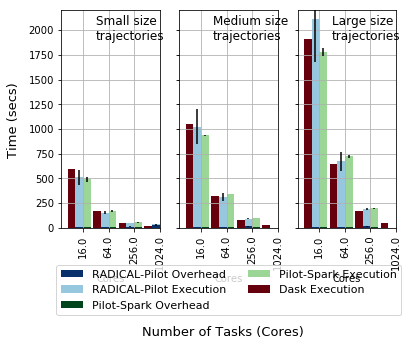

In [19]:
width=0.3
#fig, axes = plt.subplots(nrows=1, ncols=1)
fig, axes = plt.subplots(nrows=1, ncols=3)
rp_haus_short_plot.plot(kind='bar',ax=axes[0],stacked=True,sharey=True,sharex=True,width=width,position=1,yerr=rp_haus_short_plot_std,grid=True,legend=False,color=[blues(1000),blues(100)])
sp_haus_short_plot.plot(kind='bar',ax=axes[0],stacked=True,sharey=True,sharex=True,width=width,position=0,yerr=sp_haus_short_plot_std,grid=True,legend=False,color=[greens(1000),greens(100)])
rp_haus_med_plot.plot(kind='bar',ax=axes[1],stacked=True,sharey=True,sharex=True,width=width,position=1,yerr=rp_haus_med_plot_std,grid=True,legend=True,color=[blues(1000),blues(100)])
sp_haus_med_plot.plot(kind='bar',ax=axes[1],stacked=True,sharey=True,sharex=True,width=width,position=0,yerr=sp_haus_med_plot_std,grid=True,legend=True,color=[greens(1000),greens(100)])
rp_haus_long_plot.plot(kind='bar',ax=axes[2],stacked=True,sharey=True,sharex=True,width=width,position=1,yerr=rp_haus_long_plot_std,grid=True,legend=False,color=[blues(1000),blues(100)])
sp_haus_long_plot.plot(kind='bar',ax=axes[2],stacked=True,sharey=True,sharex=True,width=width,position=0,yerr=sp_haus_long_plot_std,grid=True,legend=False,color=[greens(1000),greens(100)])
DaskDataframe[DaskDataframe['Size']=='Short'].plot(kind='bar',x='Cores',y='Dask Execution',ax=axes[0],stacked=True,sharey=True,sharex=True,width=width,position=2,grid=True,legend=False,color=[reds(1000)])
DaskDataframe[DaskDataframe['Size']=='Med'].plot(kind='bar',x='Cores',y='Dask Execution',ax=axes[1],stacked=True,sharey=True,sharex=True,width=width,position=2,grid=True,legend=False,color=[reds(1000)])
DaskDataframe[DaskDataframe['Size']=='Long'].plot(kind='bar',x='Cores',y='Dask Execution',ax=axes[2],stacked=True,sharey=True,sharex=True,width=width,position=2,grid=True,legend=False,color=[reds(1000)])
axes[0].set_ylim([0,2200])
axes[1].set_ylim([0,2200])
axes[2].set_ylim([0,2200])
axes[0].text(.5,1900, 'Small size\ntrajectories', fontsize=12)
axes[1].text(.45,1900, 'Medium size\ntrajectories', fontsize=12)
axes[1].legend(fontsize=11,bbox_to_anchor=(0., -0.4, 1., .102), loc='lower center',ncol=2, borderaxespad=0.)
axes[2].text(.5,1900, 'Large size\ntrajectories', fontsize=12)
fig.text(0.5, -0.25, 'Number of Tasks (Cores)', ha='center',fontsize=13)
fig.text(0.0, 0.5, 'Time (secs)', va='center', rotation='vertical',fontsize=13)
#plt.legend(ncol=2,loc='lower center', borderaxespad=-7.5)
#plt.legend()
#plt.legend(bbox_to_anchor=(1., 2.2, .50, .102), loc=3,ncol=1, mode="expand", borderaxespad=0.)
#plt.text(-0.75,0.02,'Average Task execution time for four core counts. 128 trajectories\n\
#were compared. Each trajectory has 102 frames of 13364 atoms. The execution \n\
#partitioned the calculation of the distance matrix into the calculation of a\n\
#number of submatrices (16,64,256,1024).Resource: Comet,Date:12/9/2016')
#plt.savefig('MeanTaskBreakDownPower2LongLargeDataset.pdf',bbox_inches='tight')
#rp_haus_long_plot.plot(kind='bar',stacked=True,log=1)
#plt.title('Mean Task BreakDown. Long Trajectory ')
#plt.xlabel('Number of Units/Cores')
#plt.ylabel('Time (secs)')
#plt.text(-0.75,.05,'Average Task execution time for four core counts. 128 trajectories\n\
#were compared. Each trajectory has 102 frames of 856 atoms. The execution \n\
#partitioned the calculation of the distance matrix into the calculation of a\n\
#number of submatrices (16,64,256,1024).Resource: Comet,Date:12/1/2016')
#plt.savefig('PlotPower2LargeDataset.png',bbox_inches='tight',dpi=800)
#plt.savefig('PlotPower2LargeDataset.pdf',bbox_inches='tight',dpi=800)
plt.savefig('HausdorffStrong128TrajLargeDataset4.pdf',bbox_inches='tight',dpi=800)

In [ ]:
rp_haus_short_plot.sum(axis=1).plot(style='-*',label='RADICAL-Pilot Small Trajetory',colormap='viridis')
sp_haus_short_plot.sum(axis=1).plot(style='-*',label='Pilot-Spark Small Trajetory',colormap='Pastel2')
rp_haus_med_plot.sum(axis=1).plot(style='-^',label='RADICAL-Pilot Medium Trajetory',colormap='viridis')
sp_haus_med_plot.sum(axis=1).plot(style='-^',label='Pilot-Spark Medium Trajetory',colormap='Pastel2')
rp_haus_long_plot.sum(axis=1).plot(style='-o',label='RADICAL-Pilot Large Trajetory',colormap='viridis')
sp_haus_long_plot.sum(axis=1).plot(style='-o',label='Pilot-Spark Large Trajetory',colormap='Pastel2')
#axes.set_xscale('log', basex=2)
#axes.set_xticklabels(['16','64','256','1024'])
plt.xticks([16,64,256,1024])
plt.title('Mean Task BreakDown. Large Trajectory ')
plt.xlabel('Number of Tasks (Cores)')
plt.ylabel('Time (secs)')

In [ ]:
a = np.array([16,16,16,16], dtype=float)
b = np.array([16,64,256,1024], dtype=float)
c = a/b

times = rp_haus_short_plot.sum(axis=1).values
init = rp_haus_short_plot.sum(axis=1)[16]
eff = init/times
efficiency = eff*c
rp_short_eff_plot = efficiency
times = sp_haus_short_plot.sum(axis=1).values
init = sp_haus_short_plot.sum(axis=1)[16]
eff = init/times
efficiency = eff*c
sp_short_eff_plot = efficiency


times = rp_haus_med_plot.sum(axis=1).values
init = rp_haus_med_plot.sum(axis=1)[16]
eff = init/times
efficiency = eff*c[0:3]
rp_med_eff_plot = efficiency
times = sp_haus_med_plot.sum(axis=1).values
init = sp_haus_med_plot.sum(axis=1)[16]
eff = init/times
efficiency = eff*c
sp_med_eff_plot = efficiency

times = rp_haus_long_plot.sum(axis=1).values
init = rp_haus_long_plot.sum(axis=1)[16]
eff = init/times
efficiency = eff*c[0:3]
rp_long_eff_plot = efficiency
times = sp_haus_long_plot.sum(axis=1).values
init = sp_haus_long_plot.sum(axis=1)[16]
eff = init/times
efficiency = eff*c
sp_long_eff_plot = efficiency

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=1)
plt.plot(b,rp_short_eff_plot,'-*',label='RADICAL-Pilot Small Trajetory',color=blues(1000))
plt.plot(b,sp_short_eff_plot,'-*',label='Pilot-Spark Small Trajetory',color=greens(1000))
axes.set_xscale('log',basex=2)
plt.legend()
plt.ylim(0,1)
plt.xlabel('Number of Tasks (Cores)')
plt.ylabel('Efficiency')
fig,axes = plt.subplots(nrows=1,ncols=1)
plt.plot(b[0:3],rp_med_eff_plot,'-*',label='RADICAL-Pilot Medium Trajetory',color=blues(1000))
plt.plot(b,sp_med_eff_plot,'-*',label='Pilot-Spark Medium Trajetory',color=greens(1000))
axes.set_xscale('log',basex=2)
plt.legend()
plt.ylim(0,1)
plt.xlabel('Number of Tasks (Cores)')
plt.ylabel('Efficiency')

fig,axes = plt.subplots(nrows=1,ncols=1)
plt.plot(b[0:3],rp_long_eff_plot,'-*',label='RADICAL-Pilot Long Trajetory',color=blues(1000))
plt.plot(b,sp_long_eff_plot,'-*',label='Pilot-Spark Long Trajetory',color=greens(1000))
axes.set_xscale('log',basex=2)
plt.legend()
plt.ylim(0,1)
plt.xlabel('Number of Tasks (Cores)')
plt.ylabel('Efficiency')

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=1)
plt.plot(b,rp_short_eff_plot,'-*',label='RADICAL-Pilot Small Trajetory',color=blues(1000))
plt.plot(b,sp_short_eff_plot,'-*',label='Pilot-Spark Small Trajetory',color=greens(1000))
axes.set_xscale('log',basex=2)
plt.legend()
plt.xlabel('Number of Tasks (Cores)')
plt.ylabel('Efficiency')
fig,axes = plt.subplots(nrows=1,ncols=1)
plt.plot(b[0:3],rp_med_eff_plot,'-*',label='RADICAL-Pilot Medium Trajetory',color=blues(1000))
plt.plot(b,sp_med_eff_plot,'-*',label='Pilot-Spark Medium Trajetory',color=greens(1000))
axes.set_xscale('log',basex=2)
plt.legend()
plt.xlabel('Number of Tasks (Cores)')
plt.ylabel('Efficiency')

fig,axes = plt.subplots(nrows=1,ncols=1)
plt.plot(b[0:3],rp_long_eff_plot,'-*',label='RADICAL-Pilot Long Trajetory',color=blues(1000))
plt.plot(b,sp_long_eff_plot,'-*',label='Pilot-Spark Long Trajetory',color=greens(1000))
axes.set_xscale('log',basex=2)
plt.legend()
plt.xlabel('Number of Tasks (Cores)')
plt.ylabel('Efficiency')